## **Project Title**: Integrating Retail Demand Forecasting and Inventory Optimization to Enhance Supply Chain Efficiency



## Import Required Libraries

In [209]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load Dataset

In [210]:
# Drive Mounting

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
# Check  files in folder

datasets_list = os.listdir('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy')

for files in datasets_list:
  print(files)

sales_train_evaluation.csv
sell_prices.csv
sales_train_validation.csv
calendar.csv
sample_submission.csv
sales_merge_dataset.csv


**Note:**
1. sales_train_validation.csv is the main dataset for time-series modelling which contains daily unit sales for each item–store combination.

2. sell_prices.csv contains historical prices for each item–store which is needed to understand price elasticity

3. calendar.csv contains date-level attributes such as events, SNAP, weekdays, month, year which useful for adding event features, capturing seasonality, understanding demand spikes.

4. Skipping sales_train_evaluation.csv and sample_submission.csv because they are competition-specific files not needed for training, validation, or analysis.

In [212]:
# Load my required dateset

path = '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy'


sales = pd.read_csv(os.path.join(path, 'sales_train_validation.csv'))
calendar = pd.read_csv(os.path.join(path, 'calendar.csv'))
prices = pd.read_csv(os.path.join(path, 'sell_prices.csv'))

print("Sales shape:", sales.shape)
print("Calendar shape:", calendar.shape)
print("Prices shape:", prices.shape)

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [213]:
# Check Sales dataset
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,d_495,d_496,d_497,d_498,d_499,d_500,d_501,d_502,d_503,d_504,d_505,d_506,d_507,d_508,d_509,d_510,d_511,d_512,d_513,d_514,d_515,d_516,d_517,d_518,d_519,d_520,d_521,d_522,d_523,d_524,d_525,d_526,d_527,d_528,d_529,d_530,d_531,d_532,d_533,d_534,d_535,d_536,d_537,d_538,d_539,d_540,d_541,d_542,d_543,d_544,d_545,d_546,d_547,d_548,d_549,d_550,d_551,d_552,d_553,d_554,d_555,d_556,d_557,d_558,d_559,d_560,d_561,d_562,d_563,d_564,d_565,d_566,d_567,d_568,d_569,d_570,d_571,d_572,d_573,d_574,d_575,d_576,d_577,d_578,d_579,d_580,d_581,d_582,d_583,d_584,d_585,d_586,d_587,d_588,d_589,d_590,d_591,d_592,d_593,d_594,d_595,d_596,d_597,d_598,d_599,d_600,d_601,d_602,d_603,d_604,d_605,d_606,d_607,d_608,d_609,d_610,d_611,d_612,d_613,d_614,d_615,d_616,d_617,d_618,d_619,d_620,d_621,d_622,d_623,d_624,d_625,d_626,d_627,d_628,d_629,d_630,d_631,d_632,d_633,d_634,d_635,d_636,d_637,d_638,d_639,d_640,d_641,d_642,d_643,d_644,d_645,d_646,d_647,d_648,d_649,d_650,d_651,d_652,d_653,d_654,d_655,d_656,d_657,d_658,d_659,d_660,d_661,d_662,d_663,d_664,d_665,d_666,d_667,d_668,d_669,d_670,d_671,d_672,d_673,d_674,d_675,d_676,d_677,d

In [214]:
# Check DataFrame’s structure
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


Insights:
* It’s a wide dataset with mostly numeric daily sales data and a few categorical identifiers.

In [215]:
# Check Missing Values

missing_data = sales.isnull().sum()
missing_data[missing_data > 0]

,0


Insights:
* There is not missing value in sales dataset

In [216]:
# Check unique values in column except day column
for col in sales.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales[col].nunique()}")


id: 30490
item_id: 3049
dept_id: 7
cat_id: 3
store_id: 10
state_id: 3


**Note:**
* It is large dataset,so I will select one store & one product deppartment for my project


In [217]:
# Check statistical Summary
sales.describe()

d_1           d_2           d_3           d_4           d_5  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.070220      1.041292      0.780026      0.833454      0.627944   
std        5.126689      5.365468      3.667454      4.415141      3.379344   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      360.000000    436.000000    207.000000    323.000000    296.000000   

                d_6           d_7           d_8           d_9          d_10  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.958052      0.918662      1.244080      1.073663      0.838701   
std        4.785947      5.059495      6.617729      5.917204      4.206199   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      314.000000    316.000000    370.000000    385.000000    353.000000   

               d_11          d_12          d_13          d_14          d_15  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.756674      0.775927      0.779141      0.867334      1.142440   
std        3.665969      3.697822      3.486595      3.484608      4.636395   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      279.000000    258.000000    163.000000    107.000000    133.000000   

               d_16          d_17          d_18          d_19          d_20  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.193178      0.715120      0.789439      0.703280      0.666382   
std        4.662770      2.993414      3.296922      2.811648      2.611911   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      149.000000    122.000000    111.000000     83.000000     95.000000   

               d_21          d_22          d_23          d_24          d_25  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.777993      1.039324      0.960413      0.786028      0.672384   
std        2.985123      3.923110      3.597620      3.084773      2.874189   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      100.000000    132.000000    120.000000    113.000000    158.000000   

               d_26          d_27          d_28          d_29          d_30  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.680781      0.665038      0.738898      0.980912      0.941522   
std        2.727852      2.637849      2.842334      3.714944      3.688771   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000

In [218]:
# Check for duplicates

print(sales.duplicated().sum())

0


In [219]:
# Check count the frequency of unique values of state_ID

sales['state_id'].value_counts()

,count
state_id,
CA,12196
TX,9147
WI,9147


In [220]:
# Check count the frequency of unique values of store_id

sales['store_id'].value_counts()

,count
store_id,
CA_1,3049
CA_2,3049
CA_3,3049
CA_4,3049
TX_1,3049
TX_2,3049
TX_3,3049
WI_1,3049
WI_2,3049


In [221]:
# Check count the frequency of unique values of cat_id

sales['cat_id'].value_counts()

,count
cat_id,
FOODS,14370
HOUSEHOLD,10470
HOBBIES,5650


In [222]:
# Check count the frequency of unique values of dept_id

sales['dept_id'].value_counts()

,count
dept_id,
FOODS_3,8230
HOUSEHOLD_1,5320
HOUSEHOLD_2,5150
HOBBIES_1,4160
FOODS_2,3980
FOODS_1,2160
HOBBIES_2,1490


In [223]:
# Check unique values

print(sales['state_id'].unique())
print(sales['store_id'].unique())
print(sales['cat_id'].unique())

['CA' 'TX' 'WI']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']


## Creating subset for demonstration

In [224]:
# Creating dataset with product selling minimum 10 per day(considering day 1)

sales_filtered = sales[sales['d_1']> 10]

In [225]:
print(sales_filtered['state_id'].value_counts(),'\n')

print(sales_filtered['store_id'].value_counts(),'\n')

print(sales_filtered['cat_id'].value_counts(),'\n')

print(sales_filtered['dept_id'].value_counts(),'\n')

state_id
CA    268
WI    172
TX    145
Name: count, dtype: int64 

store_id
CA_3    91
CA_1    84
CA_2    82
WI_3    77
TX_2    67
WI_1    54
WI_2    41
TX_1    39
TX_3    39
CA_4    11
Name: count, dtype: int64 

cat_id
FOODS        449
HOBBIES       69
HOUSEHOLD     67
Name: count, dtype: int64 

dept_id
FOODS_3        349
FOODS_2         70
HOBBIES_1       69
HOUSEHOLD_1     65
FOODS_1         30
HOUSEHOLD_2      2
Name: count, dtype: int64 



In [226]:
# Creating subset by filtering to state, store, category

sales_subset = sales_filtered[(sales_filtered["state_id"] == "WI") & (sales_filtered["store_id"] == "WI_3") & (sales_filtered["cat_id"] == "FOODS") & (sales_filtered["dept_id"] == "FOODS_2")]
sales_subset.head(50)

id      item_id  dept_id cat_id store_id  \
29289  FOODS_2_021_WI_3_validation  FOODS_2_021  FOODS_2  FOODS     WI_3   
29395  FOODS_2_128_WI_3_validation  FOODS_2_128  FOODS_2  FOODS     WI_3   
29419  FOODS_2_152_WI_3_validation  FOODS_2_152  FOODS_2  FOODS     WI_3   
29431  FOODS_2_164_WI_3_validation  FOODS_2_164  FOODS_2  FOODS     WI_3   
29448  FOODS_2_181_WI_3_validation  FOODS_2_181  FOODS_2  FOODS     WI_3   
29500  FOODS_2_233_WI_3_validation  FOODS_2_233  FOODS_2  FOODS     WI_3   
29543  FOODS_2_276_WI_3_validation  FOODS_2_276  FOODS_2  FOODS     WI_3   
29627  FOODS_2_360_WI_3_validation  FOODS_2_360  FOODS_2  FOODS     WI_3   
29631  FOODS_2_364_WI_3_validation  FOODS_2_364  FOODS_2  FOODS     WI_3   
29665  FOODS_2_398_WI_3_validation  FOODS_2_398  FOODS_2  FOODS     WI_3   

      state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
29289       WI   29   24   12   40    2   25   41   36   34    18    10    38   
29395       WI   13    8   19    8    4   18   23   26    2    17     8     7   
29419       WI   12   10    9    6    4    7   12   13   17     4    11     8   
29431       WI   12   10   12    7    4   15   21   18   19     8    10    16   
29448       WI   15   26   23   19    9   33    0   11    0     0    12    35   
29500       WI   12    6    4    8   15   15    6    4    8     0     0     0   
29543       WI   22   25   20   13   29   41   20   45   35    13    24     9   
29627       WI   26   22   18    3   14   46   13   45   28    22    23    33   
29631       WI   28   34   38   59   45   38   46   16   45    59    21     4   
29665       WI   11   15   12   14    5    6   12    0    0    18     0    18   

       d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
29289    37    23    32    18    22    25    31    10    15    11    19     9   
29395    16     1    26    20    18    27    26    11    21    14    12     4   
29419    10    13    16    15    10    12     4     0     7     9    10    10   
29431     9     9    11     9     5    14     4     3     5     0     0     0   
29448     0    20    25    37    20    34    16    14     9    15    17     7   
29500    15    10    18    16    10     8    15    13    11     9     5    12   
29543     5     3     0    51    32    29    32    24    14    28    18    23   
29627    17    46    53    34    36    47    69     9    28    24    21    22   
29631    59    50    75    18    27    33    15    27    20    17    14    11   
29665    21     9    25    10    18    12    12     9     9     0     6    14   

       d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
29289    16    16     6     5     5    21     2    13    31    11    28    39   
29395    15     6     8     8     6    16     3    11    16     6    17    20   
29419     7    10     5     4     6     6     5     3     4     8     1     6   
29431     8     7     2     6     9    12     4    10     8    10    15    13   
29448    15    12    16    17    20    16    10    14    32    27     8     4   
29500     7     5     8     7    14     8    10    10    14    12    16    13   
29543    13    18     4     8    19    26    16    12    16    18    15    24   
29627    30    28    21     7    27    49    16     8    53    36    45    35   
29631     4     7    13    11    11    14    13    11    19    20    17    13   
29665     7     4     6    12     9     8    13    10     8    12     8    23   

       d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
29289    49    12    23    25    24    24    20    18    24    27    26    25   
29395    20     1     0     0     8    16    24     0    12     7     5    10   
29419     6     5     6     1     8     2    10     3     1     6     4     1   
29431    10     6     6    17     2     4     9    13     5    13     6     5   
29448    32    13    14    19    18    22    35    26    26    42    12    12   
29500    18    15     6    16    

In [227]:
sales_subset.shape

(10, 1919)

In [228]:
# Re-Check unique values in column except day column
for col in sales_subset.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales_subset[col].nunique()}")

id: 10
item_id: 10
dept_id: 1
cat_id: 1
store_id: 1
state_id: 1


## Transforming Sales Data: Wide to Long Format

In [229]:
# Melt the sales data from wide (d_1, d_2…) to long format

id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(sales_subset,id_vars=id_vars,var_name="d",value_name="sales")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12


In [230]:
# Check data structure
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19130 non-null  object
 1   item_id   19130 non-null  object
 2   dept_id   19130 non-null  object
 3   cat_id    19130 non-null  object
 4   store_id  19130 non-null  object
 5   state_id  19130 non-null  object
 6   d         19130 non-null  object
 7   sales     19130 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


In [231]:
# Convert the "d" column (like "d_1", "d_2") into a numeric day index

sales_long["day_number"] = sales_long["d"].str.extract(r"_(\d+)").astype(int)
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1


**Note:**

The \d+ in the regular expression means “match one or more digits”.

\d → matches any single digit (0–9)

'+' → means “one or more times”

So \d+ will match numbers like 1, 12, 1913, etc.

In [232]:
# Check calendar dataset
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [233]:
# Merge with calendar by "d" column that matches the "d" in sales_long
sales_long = sales_long.merge(calendar, how="left", on="d")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [234]:
# Check prices dataset
prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [235]:
# Merge with prices by wm_yr_wk

sales_long = sales_long.merge(prices,on=["store_id", "item_id", "wm_yr_wk"],how="left")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.98


**Note:**

If I merged only on wm_yr_wk, I could get:

Prices from a different item in the same week or

Prices from a different store in the same week

So , I used "store_id", "item_id", "wm_yr_wk"

In [236]:
# Check final columns  name
sales_long.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

## Basic overview with Final Dataset

In [237]:
# Data structure of final dataset
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  1540 non-null   object 
 16  event_type_1  1540 non-null   object 
 17  event_name_2  40 non-null     object 
 18  event_type_2  40 non-null 

In [238]:
sales_long.describe()

,sales,day_number,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000
mean,7.062520,957.000000,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,2.254731
std,9.594391,552.249891,150.378111,2.000704,3.458864,1.532126,0.469981,0.469981,0.469981,1.122140
min,0.000000,1.000000,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.640000
25%,0.000000,479.000000,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.940000
50%,4.000000,957.000000,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,2.420000
75%,10.000000,1435.000000,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,2.980000
max,83.000000,1913.000000,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,4.480000


In [239]:
# Check shape of our final dataset

sales_long.shape

(19130, 23)

In [240]:
# Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0
event_name_1,17590
event_type_1,17590
event_name_2,19090
event_type_2,19090


In [242]:
# Fill missing events with "No Event"

sales_long['event_name_1'].fillna('No Event', inplace=True)
sales_long['event_type_1'].fillna('No Event', inplace=True)
sales_long['event_name_2'].fillna('No Event', inplace=True)
sales_long['event_type_2'].fillna('No Event', inplace=True)

In [243]:
# Recheck Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0


In [244]:
# Check any duplicated values

sales_long.duplicated().sum()

np.int64(0)

In [245]:
# Check filtered dataset
sales_long.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
19125,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,4.48
19126,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,d_1913,9,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,3.42
19127,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,d_1913,6,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,0.94
19128,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,d_1913,5,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.74
19129,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.43


In [246]:
# Save final dataset

sales_long.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv', index=False)

## Load saved final dataset ( Store : WI_3, Dept : FOODS_2)

In [247]:
Sales_df = pd.read_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv')

## Basic overview

In [248]:
# Show all columns

pd.set_option('display.max_columns', None)

In [249]:
Sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,11101,Saturday,1,1,2011,No Event,No Event,No Event,No Event,0,0,0,0.64
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,11101,Saturday,1,1,2011,No Event,No Event,No Event,No Event,0,0,0,0.64
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,11101,Saturday,1,1,2011,No Event,No Event,No Event,No Event,0,0,0,1.98


In [250]:
Sales_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
19125,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,4.48
19126,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,d_1913,9,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,3.42
19127,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,d_1913,6,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,0.94
19128,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,d_1913,5,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.74
19129,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,11613,Sunday,2,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.43


In [256]:
Sales_df.isnull().sum()

,0
id,0
item_id,0
dept_id,0
cat_id,0
store_id,0
state_id,0
d,0
sales,0
day_number,0
date,0


In [257]:
Sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  19130 non-null  object 
 16  event_type_1  19130 non-null  object 
 17  event_name_2  19130 non-null  object 
 18  event_type_2  19130 non-nu

In [258]:
Sales_df.describe()

,sales,day_number,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000
mean,7.062520,957.000000,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,2.254731
std,9.594391,552.249891,150.378111,2.000704,3.458864,1.532126,0.469981,0.469981,0.469981,1.122140
min,0.000000,1.000000,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.640000
25%,0.000000,479.000000,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.940000
50%,4.000000,957.000000,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,2.420000
75%,10.000000,1435.000000,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,2.980000
max,83.000000,1913.000000,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,4.480000


What to write in dissertation

Dataset contains transactional daily sales at item–store level

No missing values in target (sales)

Calendar, price, SNAP, and event variables enrich demand signals

# Exploratory Data Analysis (EDA)

I will check sales patterns and price/promotion effects which are critical for demand forecasting and inventory optimization

## Target Variable Analysis (Sales)

### Sales distribution

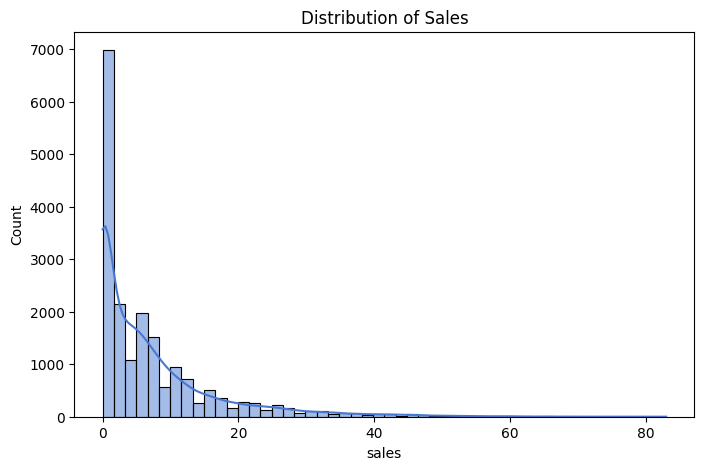

In [266]:
# Distribution of sales
plt.figure(figsize=(8,5))
sns.histplot(Sales_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/distribution_of_sales.png")
plt.show()

### Zero-sales proportion (important for inventory risk)

In [260]:
zero_ratio = (Sales_df['sales'] == 0).mean() * 100
print(f"Zero-sales days: {zero_ratio:.2f}%")


Zero-sales days: 31.90%


### Outlier detection

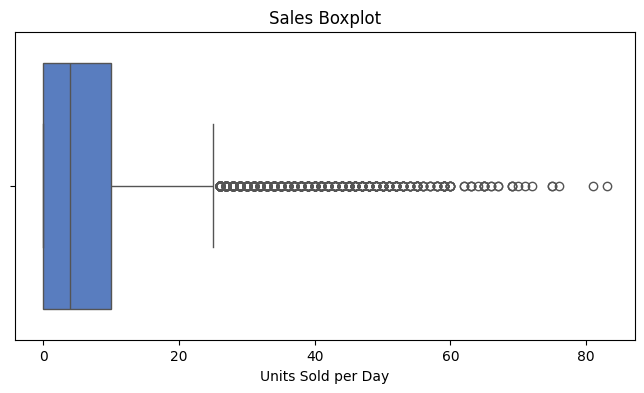

In [267]:
plt.figure(figsize=(8,4))
sns.boxplot(x='sales', data=Sales_df)
plt.title('Sales Boxplot')
plt.xlabel('Units Sold per Day')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_boxplot.png")
plt.show()

Dissertation insight

Retail demand is sparse and intermittent

High zero-sales frequency motivates safety stock modelling

## Time Series Behaviour (Trend & Seasonality)

Purpose: justify time-series and deep learning models.

### Convert date

In [264]:
# Convert 'date' to datetime
Sales_df['date'] = pd.to_datetime(Sales_df['date'])

### Aggregate overall sales trend

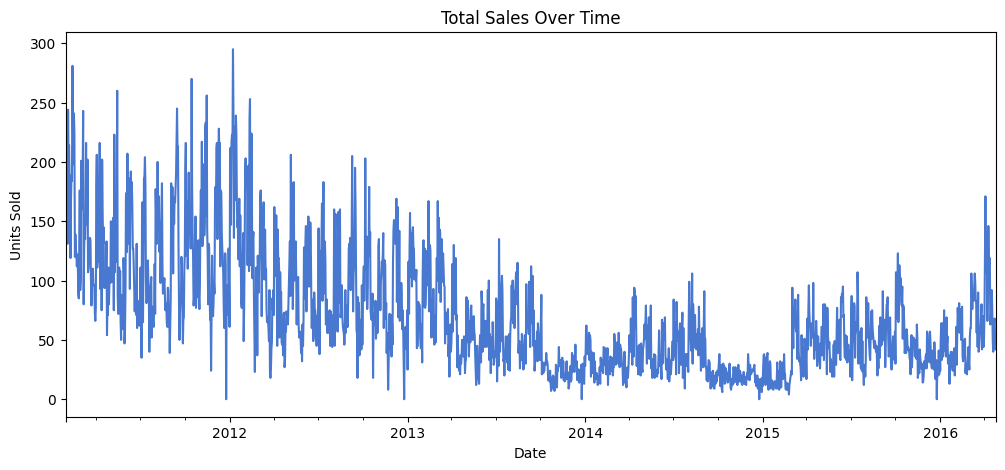

In [268]:
# Aggregate sales by date and sort
daily_sales = Sales_df.groupby('date')['sales'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total_sales_over_time.png")
plt.show()

In [269]:
daily_sales.head()

,sales
date,
2011-01-29,180
2011-01-30,180
2011-01-31,167
2011-02-01,177
2011-02-02,131


### Rolling mean (trend smoothing)

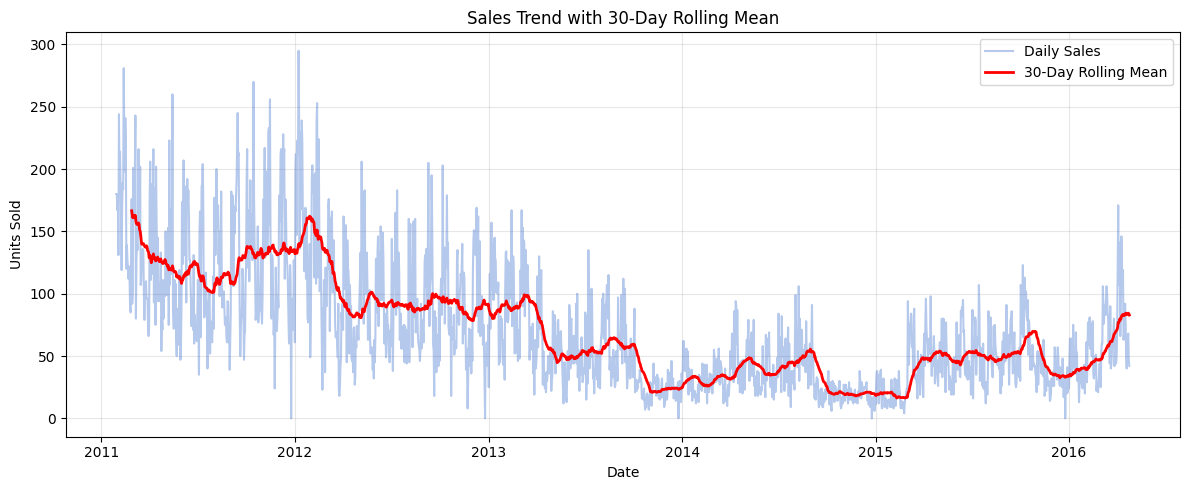

In [270]:
rolling_30 = daily_sales.rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, alpha=0.4,label='Daily Sales')
plt.plot(rolling_30.index, rolling_30.values,linewidth=2, color='red',label='30-Day Rolling Mean')
plt.title('Sales Trend with 30-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_trend_with_rolling_mean.png")
plt.tight_layout()
plt.show()

Dissertation insight

Clear temporal dependency → forecasting models are appropriate

Rolling trend informs reorder frequency

## Weekly & Yearly Seasonality

Purpose: justify seasonal parameters (e.g. 7-day seasonality).

In [271]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

### Weekly pattern

In [272]:
# Checking if weekday & number in same order

Weekday = {}
Weekday_number = {}

for i in Sales_df['wday'].unique():
  Weekday = Sales_df[Sales_df['wday']==i]['weekday'].unique()
  Weekday_number = i
  print(f"Weekday {Weekday_number}: {Weekday}")

Weekday 1: ['Saturday']
Weekday 2: ['Sunday']
Weekday 3: ['Monday']
Weekday 4: ['Tuesday']
Weekday 5: ['Wednesday']
Weekday 6: ['Thursday']
Weekday 7: ['Friday']


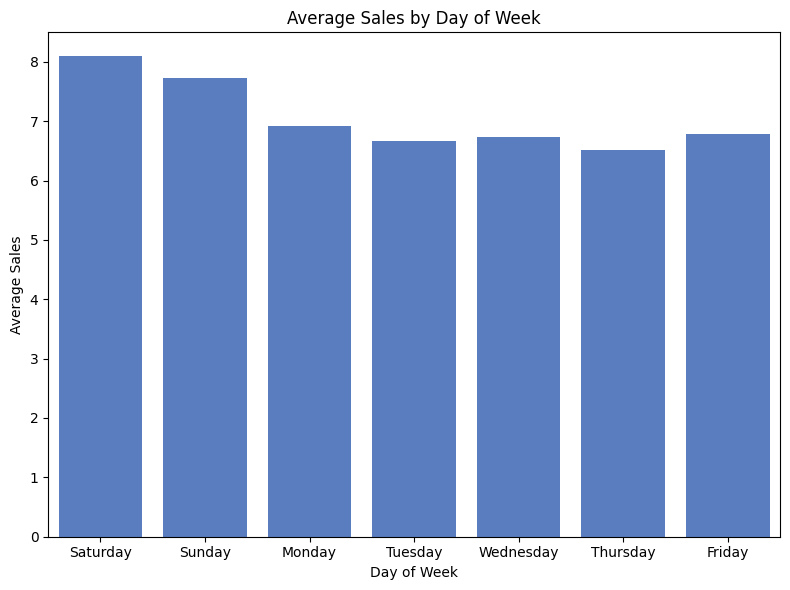

In [277]:
weekly_pattern = Sales_df.groupby('weekday')['sales'].mean().reindex(Sales_df['weekday']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='weekday', y='sales', data=weekly_pattern)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by day of week.png")
plt.tight_layout()
plt.show()


### Monthly pattern

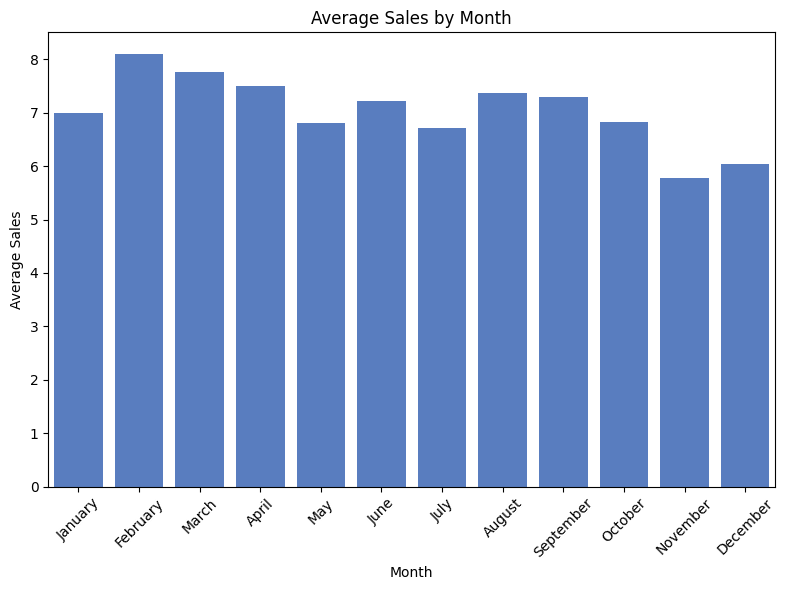

In [278]:
Sales_df['month_name'] = Sales_df['date'].dt.month_name()

monthly_pattern = Sales_df.groupby('month_name')['sales'].mean().reindex(Sales_df['month_name']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='month_name', y='sales', data=monthly_pattern)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by month.png")
plt.tight_layout()
plt.show()


Dissertation insight

Strong weekly seasonality supports SARIMA and Holt-Winters

Month effects justify calendar features in ML models

## Item level sales Behaviour

Purpose: show demand heterogeneity (important for inventory policy).

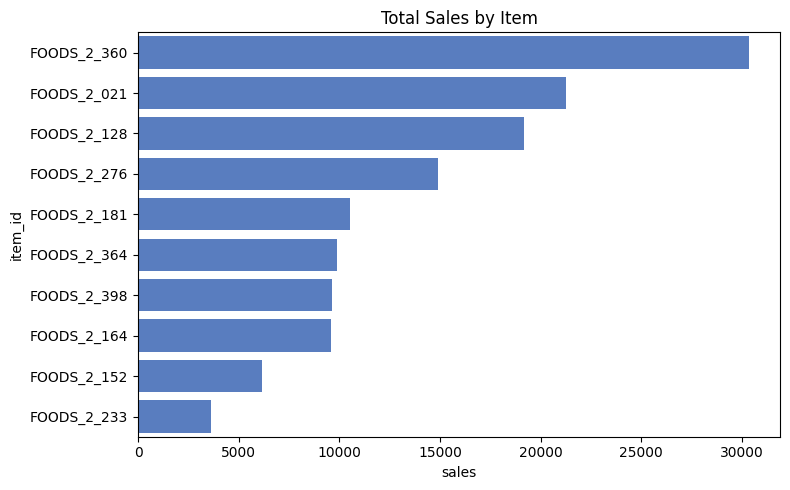

In [310]:
store_sales = Sales_df.groupby('item_id')['sales'].sum().reset_index()

# Sort in descending order before plotting
store_sales = store_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='sales', y='item_id', data=store_sales)
plt.title('Total Sales by Item')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total sales by item.png")
plt.tight_layout()
plt.show()

## Price Effect Analysis
Purpose: connect demand forecasting with cost-based inventory decisions.

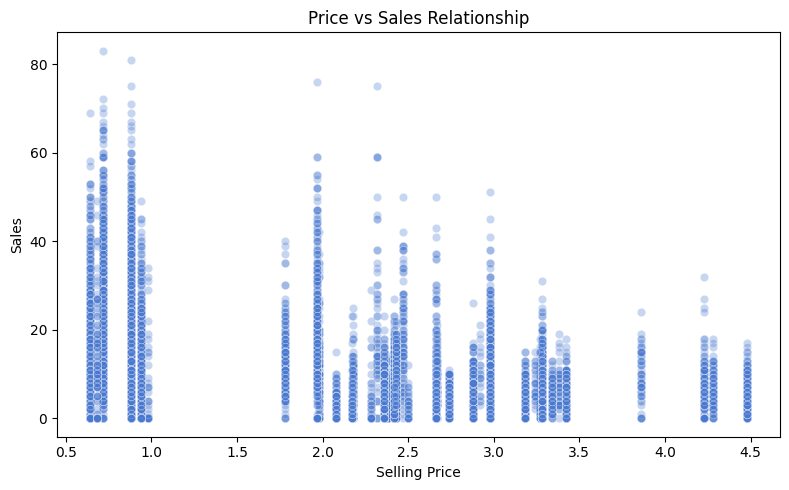

In [280]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='sell_price', y='sales', data=Sales_df, alpha=0.3)
plt.title('Price vs Sales Relationship')
plt.xlabel('Selling Price')
plt.ylabel('Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/price vs sales relationship.png")
plt.tight_layout()
plt.show()


Dissertation insight

Price sensitivity affects order quantity decisions

Useful for avoiding overstock on high-price items

## Promotion & Event Impact
Purpose: justify exogenous variables.

### SNAP effect

In [284]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'month_name',
       'price_bin'],
      dtype='object')

In [285]:
Sales_df['snap_WI'].unique()

array([0, 1])

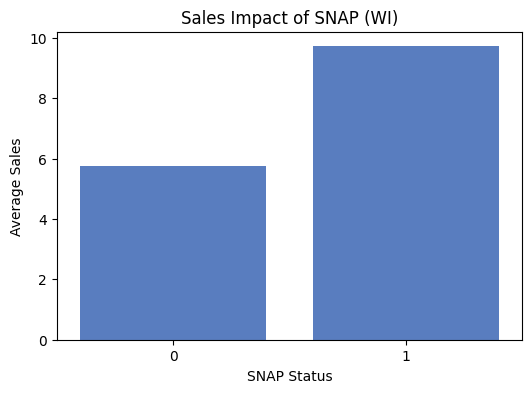

In [311]:
snap_effect = Sales_df.groupby('snap_WI')['sales'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='snap_WI', y='sales', data=snap_effect)
plt.title('Sales Impact of SNAP (WI)')
plt.xlabel('SNAP Status')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales impact of snap (WI).png")
plt.show()


In [287]:
Sales_df['event_type_1'].unique()

array(['No Event', 'Sporting', 'Cultural', 'National', 'Religious'],
      dtype=object)

In [288]:
Sales_df['event_name_1'].unique()

array(['No Event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [289]:
Sales_df['event_type_2'].unique()

array(['No Event', 'Cultural', 'Religious'], dtype=object)

In [290]:
Sales_df['event_name_2'].unique()

array(['No Event', 'Easter', 'Cinco De Mayo', 'OrthodoxEaster',
       "Father's day"], dtype=object)

### Events Effect

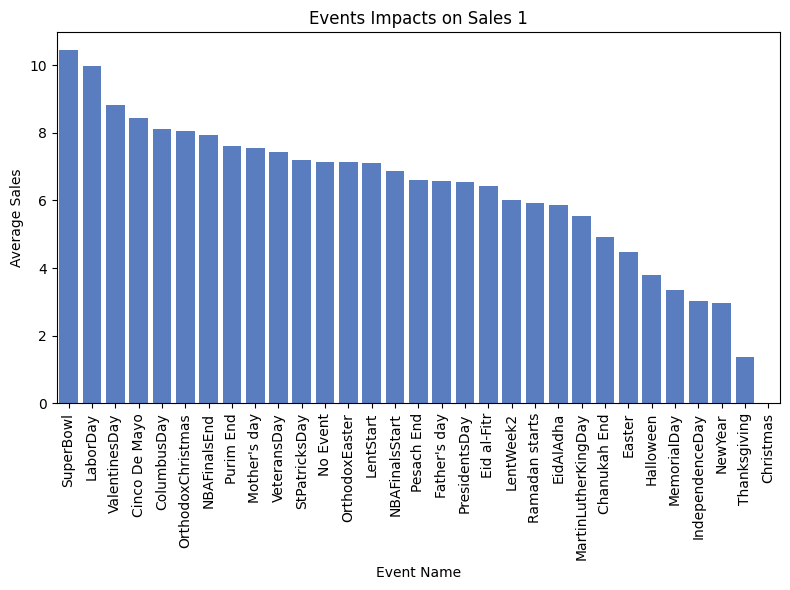

In [297]:
event_sales = Sales_df.groupby('event_name_1')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_1', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 1')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 1.png")
plt.tight_layout()
plt.show()


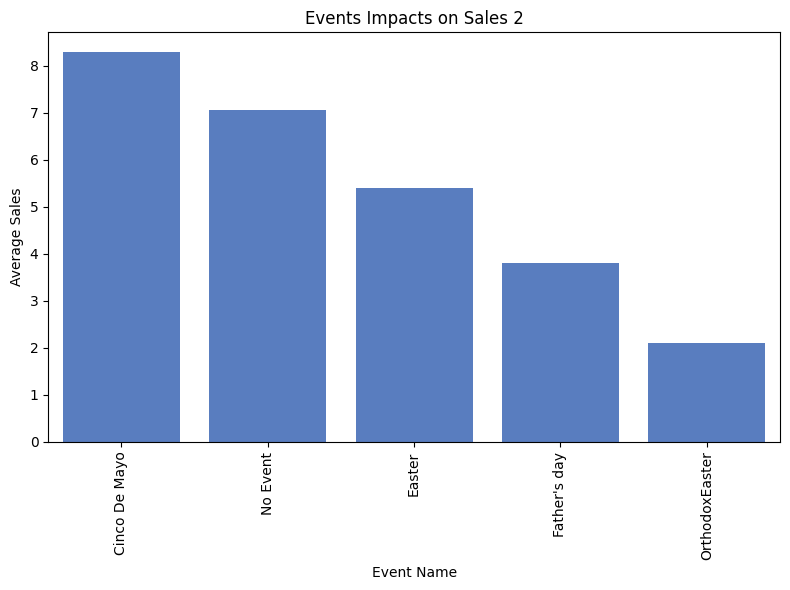

In [296]:
event_sales = Sales_df.groupby('event_name_2')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_2', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 2')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 2.png")
plt.tight_layout()
plt.show()

Dissertation insight

Promotions and events significantly influence demand

Ignoring them leads to poor inventory planning

##Correlation Analysis (Numerical Features)

Purpose: feature selection justification.

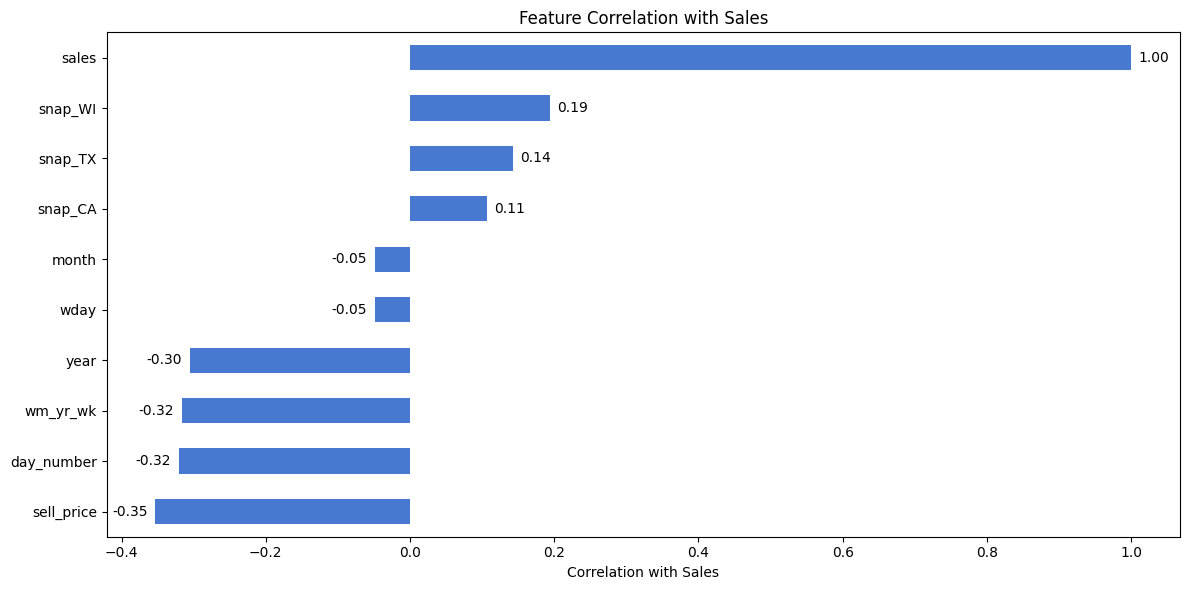

In [308]:
num_cols = ['sales','sell_price','day_number','wm_yr_wk','wday','month','year','snap_CA','snap_TX','snap_WI']
corr_with_sales = sales_long[num_cols].corr()['sales'].sort_values()

plt.figure(figsize=(12,6))
ax = corr_with_sales.plot(kind='barh')

# Add value labels
for i, v in enumerate(corr_with_sales):
    ax.text(
        v + 0.01 if v > 0 else v - 0.06,  # position
        i,
        f"{v:.2f}",
        va='center'
    )

plt.xlabel('Correlation with Sales')
plt.title('Feature Correlation with Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/feature_correlation_with_sales.png")
plt.tight_layout()
plt.show()

# **Correct  upto EDA**

## Log Transformation to convert to normal data

In [ ]:
sales_long['sales'] = np.log1p(sales_long['sales'])

In [ ]:
# Check distribution after transformation
plt.figure(figsize=(8,5))
sns.histplot(sales_long['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("distribution_of_sales.png")
plt.show()

## Price Features

In [ ]:
sales_long['price'] = sales_long['sell_price']

# Price change from previous week
sales_long = sales_long.sort_values(['item_id','store_id','date'])
sales_long['price_change_from_last_week'] = sales_long.groupby(['item_id','store_id'])['price'].diff(7)

# 7-day rolling mean price
sales_long['rolling_mean_price_7d'] = sales_long.groupby(['item_id','store_id'])['price'].transform(lambda x: x.rolling(7, min_periods=1).mean())

## Demand / Sales Features

In [ ]:
# Lag features (A lag feature is a value from a previous time step used as a predictor for the current time step.)
sales_long['lag_7'] = sales_long.groupby(['item_id','store_id'])['sales'].shift(7)
sales_long['lag_28'] = sales_long.groupby(['item_id','store_id'])['sales'].shift(28)

# Rolling mean / std (A rolling mean computes the average of a window of consecutive past values.)
sales_long['rolling_mean_7d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
sales_long['rolling_mean_28d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(28, min_periods=1).mean())
sales_long['rolling_std_7d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).std())

#  Fill NaN for initial periods

sales_long.fillna(0, inplace=True)


## Check new features

In [ ]:
sales_long[['date','item_id','store_id','sales','lag_7','lag_28','rolling_mean_7d','rolling_mean_28d','rolling_std_7d','price','price_change_from_last_week','rolling_mean_price_7d','day_of_week','week_of_year','month','year','is_weekend','has_event']].head()


In [ ]:
# Correlation check (numeric features only)
numeric_features = ['sales', 'lag_7','lag_28','rolling_mean_7d','rolling_mean_28d',
                    'rolling_std_7d','price','price_change_from_last_week','rolling_mean_price_7d',
                    'day_of_week','week_of_year','month','year','is_weekend','has_event']

corr_matrix = sales_long[numeric_features].corr()
print("Correlation with target (sales):")
print(corr_matrix['sales'].sort_values(ascending=False))

# visualize correlation

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


## Holt-Winters Model

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Dictionary to store forecasts for each item
hw_forecasts = {}
test_sets = {}  # store corresponding test sets

items = sales_long['item_id'].unique()

for item in items:
    # Extract time series for this item
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Split into train and test
    train = ts[:-28]  # last 28 days as test
    test = ts[-28:]

    # Fit Holt-Winters model
    hw_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7).fit()

    # Forecast
    hw_forecast = hw_model.forecast(28)

    # Store forecast
    hw_forecasts[item] = hw_forecast
    test_sets[item] = test


In [ ]:
forecast_df = pd.DataFrame(hw_forecasts)
forecast_df.index = test.index  # set test dates as index
forecast_df.T

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Dictionary to store test sets (you already created test_sets during model building)
# test_sets = {}

# List to store evaluation metrics
hw_eval = []

for item in items:
    # Get actual sales from stored test set
    test = test_sets[item]

    # Get forecast
    hw_forecast = hw_forecasts[item]

    # Compute metrics
    mae = mean_absolute_error(test, hw_forecast)
    rmse = np.sqrt(mean_squared_error(test, hw_forecast))
    mape = np.mean(np.abs((test - hw_forecast) / test.replace(0, np.nan))) * 100

    hw_eval.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert to DataFrame
hw_eval_df = pd.DataFrame(hw_eval)

# Overall average metrics
overall_metrics = hw_eval_df[['MAE', 'RMSE', 'MAPE (%)']].mean()
print("Holt-Winters Overall Metrics:\n", overall_metrics)



In [ ]:
# Top 10 items with highest MAPE
top_mape_items = hw_eval_df.sort_values('MAPE (%)', ascending=False).head(10)
print("Top 10 items with highest MAPE:\n", top_mape_items)


##SARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_forecasts = {}  # to store forecasts for each item
test_sets = {}  # store corresponding test sets

items = sales_long['item_id'].unique()

for item in items:
    # Extract time series for the item
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Split into train and test
    train = ts[:-28]  # last 28 days as test
    test = ts[-28:]

    # Fit SARIMA model
    sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)

    # Forecast
    sarima_forecast = sarima_model.forecast(len(test))

    # Store forecast & test values for evaluation
    sarima_forecasts[item] = sarima_forecast
    test_sets[item] = test


In [ ]:
sarima_forecast_df = pd.DataFrame(sarima_forecasts)
sarima_forecast_df.index = test.index
sarima_forecast_df.T


## Evaluation Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# List to store evaluation metrics
sarima_eval = []

for item in items:
    # Retrieve forecast and corresponding test set
    sarima_forecast = sarima_forecasts[item]
    test = test_sets[item]

    # Compute MAE
    mae = mean_absolute_error(test, sarima_forecast)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

    # Compute MAPE, avoid division by zero
    test_nonzero = test.replace(0, np.nan)
    mape = np.mean(np.abs((test_nonzero - sarima_forecast) / test_nonzero)) * 100

    sarima_eval.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert to DataFrame
sarima_eval_df = pd.DataFrame(sarima_eval)

# Overall average metrics
overall_metrics = sarima_eval_df[['MAE','RMSE','MAPE (%)']].mean()
print("SARIMA Overall Metrics:\n", overall_metrics)


In [ ]:
# Top 10 items with highest MAPE
top_mape_items = sarima_eval_df.sort_values('MAPE (%)', ascending=False).head(10)
print("Top 10 items with highest MAPE:\n", top_mape_items)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 20 items by RMSE for visualization
top_items = sarima_eval_df.sort_values('RMSE', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x='item_id', y='RMSE', data=top_items)
plt.xticks(rotation=90)
plt.title('Top 20 Items by RMSE (SARIMA)')
plt.xlabel('Item ID')
plt.ylabel('RMSE')
plt.show()

# Plot MAPE distribution for all items
plt.figure(figsize=(10,5))
sns.histplot(sarima_eval_df['MAPE (%)'], bins=30, kde=True)
plt.title('MAPE Distribution Across Items')
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')
plt.show()

# Compare actual vs forecast for a single example item
example_item = items[0]
test = test_sets[example_item]
forecast = sarima_forecasts[example_item]

plt.figure(figsize=(12,5))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, forecast.values, label='Forecast', linestyle='--')
plt.title(f'Actual vs Forecast for {example_item}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

for item in items:
    test = test_sets[item]  # actual sales
    forecast = sarima_forecasts[item]  # SARIMA forecast

    plt.figure(figsize=(12,4))
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, forecast.values, label='Forecast', linestyle='--')
    plt.title(f'Actual vs Forecast for {item}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


In [ ]:
comparison_df = hw_eval_df.merge(sarima_eval_df, on='item_id', suffixes=('_HW', '_SARIMA'))
comparison_df.head()


In [ ]:
comparison_df['Best_Model_MAE'] = np.where(comparison_df['MAE_HW'] < comparison_df['MAE_SARIMA'], 'HW', 'SARIMA')
comparison_df['Best_Model_RMSE'] = np.where(comparison_df['RMSE_HW'] < comparison_df['RMSE_SARIMA'], 'HW', 'SARIMA')
comparison_df['Best_Model_MAPE'] = np.where(comparison_df['MAPE (%)_HW'] < comparison_df['MAPE (%)_SARIMA'], 'HW', 'SARIMA')


In [ ]:
best_mae_count = comparison_df['Best_Model_MAE'].value_counts()
best_rmse_count = comparison_df['Best_Model_RMSE'].value_counts()
best_mape_count = comparison_df['Best_Model_MAPE'].value_counts()

print("Number of items where HW has lower MAE:", best_mae_count.get('HW',0))
print("Number of items where SARIMA has lower MAE:", best_mae_count.get('SARIMA',0))
print("Number of items where HW has lower RMSE:", best_rmse_count.get('HW',0))
print("Number of items where SARIMA has lower RMSE:", best_rmse_count.get('SARIMA',0))
print("Number of items where HW has lower MAPE:", best_mape_count.get('HW',0))
print("Number of items where SARIMA has lower MAPE:", best_mape_count.get('SARIMA',0))


In [ ]:
overall_avg = pd.DataFrame({
    'HW': comparison_df[['MAE_HW', 'RMSE_HW', 'MAPE (%)_HW']].mean(),
    'SARIMA': comparison_df[['MAE_SARIMA', 'RMSE_SARIMA', 'MAPE (%)_SARIMA']].mean()
})
print(overall_avg)


In [ ]:
import matplotlib.pyplot as plt

overall_avg.plot(kind='bar', figsize=(8,5))
plt.title('Average Evaluation Metrics: HW vs SARIMA')
plt.ylabel('Metric Value')
plt.show()


###  Feature Scaling for LSTM/GRU

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Dictionary to store evaluation metrics
lstm_forecasts = {}  # To store forecast for each item
lstm_true = {}       # To store actual values for each item
lstm_eval = []       # To store evaluation metrics

# Get all unique items
items = sales_long['item_id'].unique()

# Loop through each item
for item in items:
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts_values = ts['sales'].values.reshape(-1, 1)

    # Normalize
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts_values)

    # Train/Validation split
    train_size = int(len(ts_scaled) * 0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    # Create sequences
    def create_sequences(data, window_size=28):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i-window_size:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    window_size = 28
    X_train, y_train = create_sequences(train, window_size)
    X_val, y_val = create_sequences(val, window_size)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

    # Forecast
    y_pred_scaled = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_val)

    # Store predictions and actuals
    lstm_forecasts[item] = y_pred.flatten()
    lstm_true[item] = y_true.flatten()

    # Evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.nanmean(np.abs((y_true - y_pred) / np.where(y_true==0, np.nan, y_true))) * 100

    # Append results
    lstm_eval.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert to DataFrame
lstm_eval_df = pd.DataFrame(lstm_eval)


In [ ]:
# Overall average metrics
overall_metrics = lstm_eval_df[['MAE','RMSE','MAPE (%)']].mean()
print("LSTM Overall Metrics:\n", overall_metrics)



In [ ]:
# Top 10 items with highest MAPE
top_mape_items = lstm_eval_df.sort_values('MAPE (%)', ascending=False).head(10)
print("Top 10 items with highest MAPE:\n", top_mape_items)

## Evaluation Metrics

In [ ]:
item = 'FOODS_2_398'
y_true = lstm_true[item]      # actual values for this item
y_pred = lstm_forecasts[item] # forecasted values for this item

plt.figure(figsize=(12,5))
plt.plot(y_true, label='Actual Sales', marker='o')
plt.plot(y_pred, label='LSTM Forecast', marker='s')
plt.title(f'Forecast vs Actual for {item}')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='s', label='Validation Loss')
plt.title('LSTM Model Training History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(range(0, len(history.history['loss']), 1))
plt.show()


## GRU Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

gru_forecasts = {}  # To store forecasts for each item
gru_true = {}       # To store actual values for each item
gru_eval = []       # To store evaluation metrics

items = sales_long['item_id'].unique()

for item in items:
    ts = sales_long[sales_long['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Scale
    ts_values = ts.values.reshape(-1,1)
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts_values)

    # Train-validation split
    train_size = int(len(ts_scaled)*0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    # Sequence creation
    def create_sequences(data, window_size=28):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i-window_size:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train)
    X_val, y_val = create_sequences(val)

    # Build GRU model
    model = Sequential()
    model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history_gru = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)

    # Forecast
    y_pred_scaled = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_val)

    # Store predictions and actuals
    gru_forecasts[item] = y_pred.flatten()
    gru_true[item] = y_actual.flatten()

    # Evaluation
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mape = np.mean(np.abs((y_actual - y_pred)/np.where(y_actual==0, np.nan, y_actual)))*100

    gru_eval.append({'item_id': item, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape})

# Convert evaluation to DataFrame
gru_eval_df = pd.DataFrame(gru_eval)
overall_metrics = gru_eval_df[['MAE','RMSE','MAPE (%)']].mean()
print("GRU Overall Metrics:\n", overall_metrics)


In [ ]:
#  Plot Forecast

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual')
plt.plot(y_gru, label='GRU Forecast')
plt.title(f'GRU Forecast for {item} in TX_1')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Plot Training History

plt.figure(figsize=(8,5))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:

forecast_gru = y_gru.flatten()

forecast_28_gru = forecast_gru[:28]

# create date index for the next 28 days
future_dates = pd.date_range(start='2025-01-01', periods=28, freq='D')

# build dataframe
df_forecast = pd.DataFrame({
    'date': future_dates,
    'forecast': forecast_28_gru
})

print('Forecast for next 7 days')
df_forecast.head(7)

## Comparison

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you already have evaluation DataFrames:
# lstm_eval_df, gru_eval_df, sarima_eval_df, hw_eval_df
# Each with columns: ['item_id', 'MAE', 'RMSE', 'MAPE (%)']

# Add a column for model name
lstm_eval_df['Model'] = 'LSTM'
gru_eval_df['Model'] = 'GRU'
sarima_eval_df['Model'] = 'SARIMA'
hw_eval_df['Model'] = 'Holt-Winters'

# Combine all evaluations
combined_eval = pd.concat([lstm_eval_df, gru_eval_df, sarima_eval_df, hw_eval_df], ignore_index=True)

# Compute overall metrics per model
overall_metrics = combined_eval.groupby('Model')[['MAE', 'RMSE', 'MAPE (%)']].mean().reset_index()
print("Overall Metrics by Model:\n", overall_metrics)

# Plot comparison
plt.figure(figsize=(12,5))

# MAE
plt.subplot(1,3,1)
sns.barplot(x='Model', y='MAE', data=overall_metrics)
plt.title('MAE Comparison')
plt.ylabel('MAE')

# RMSE
plt.subplot(1,3,2)
sns.barplot(x='Model', y='RMSE', data=overall_metrics)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

# MAPE
plt.subplot(1,3,3)
sns.barplot(x='Model', y='MAPE (%)', data=overall_metrics)
plt.title('MAPE (%) Comparison')
plt.ylabel('MAPE (%)')

plt.tight_layout()
plt.show()


In [ ]:
# Rank by RMSE

df_metrics['Rank'] = df_metrics['RMSE'].rank(method='min')
df_metrics = df_metrics.sort_values('Rank')
df_metrics

## Select the best forecast model

In [ ]:
# GRU was best
forecast = y_gru.flatten()
actual = y_true.flatten()
dates = ts.index[-len(forecast):]

## Hyperparameter Tuning

In [ ]:
!pip install optuna

## Bayesian optimization-inspired approach

In [ ]:
import optuna


def create_gru_model(trial):
    model = Sequential()

    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 1, 3)
    for i in range(n_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128, step=32)
        return_seq = True if i < n_layers - 1 else False
        model.add(GRU(
            units=units,
            activation='relu',
            return_sequences=return_seq,
            input_shape=(X_train.shape[1], 1) if i == 0 else None
        ))
        dropout = trial.suggest_float(f"dropout_l{i}", 0.1, 0.5, step=0.1)
        model.add(Dropout(dropout))

    model.add(Dense(1))  # regression output

    # Optimizer learning rate
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def objective(trial):
    model = create_gru_model(trial)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])  # take the best validation loss
    return val_loss

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Print best parameters
print("Best trial:")
trial = study.best_trial
print(trial.params)

In [ ]:
print("Best hyperparameters:")
print(study.best_trial.params)

Best hyperparameters:
{'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.2, 'units_l1': 96, 'dropout_l1': 0.30000000000000004, 'units_l2': 32, 'dropout_l2': 0.5, 'learning_rate': 0.009612576695163955, 'batch_size': 32}

In [ ]:
best_params = {
    'n_layers': 3,
    'units_l0': 64,
    'dropout_l0': 0.2,
    'units_l1': 96,
    'dropout_l1': 0.3,
    'units_l2': 32,
    'dropout_l2': 0.5,
    'learning_rate': 0.009612576695163955,
    'batch_size': 32
}

# Build GRU model
gru_model = Sequential()

# Layer 0
gru_model.add(GRU(
    units=best_params['units_l0'],
    activation='relu',
    return_sequences=True,
    input_shape=(X_train.shape[1], 1)
))
gru_model.add(Dropout(best_params['dropout_l0']))

# Layer 1
gru_model.add(GRU(
    units=best_params['units_l1'],
    activation='relu',
    return_sequences=True
))
gru_model.add(Dropout(best_params['dropout_l1']))

# Layer 2 (final GRU layer)
gru_model.add(GRU(
    units=best_params['units_l2'],
    activation='relu',
    return_sequences=False
))
gru_model.add(Dropout(best_params['dropout_l2']))

# Output layer
gru_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=best_params['learning_rate'])
gru_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Train the model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )]
)


In [ ]:
# Forecast on Validation
y_gru_scaled = gru_model.predict(X_val)

# Inverse scale predictions
y_gru = scaler.inverse_transform(y_gru_scaled)

# Inverse scale true values
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Flatten for plotting or metrics
y_gru = y_gru.flatten()
y_true = y_true.flatten()


In [ ]:
# To ensure predictions and true values are flat arrays
y_pred = y_gru.reshape(-1)
y_true_flat = y_true.reshape(-1)

# Evaluation metrics
rmse_gru = np.sqrt(mean_squared_error(y_true_flat, y_pred))
mae_gru = mean_absolute_error(y_true_flat, y_pred)

print(f"GRU Forecast - RMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}")


In [ ]:
#  Plot Forecast

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_gru, label='GRU Forecast', color='orange')
plt.title(f'GRU Forecast vs Actual for {item} in TX_1')
plt.xlabel('Time Step (Days)')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plot Training History

plt.figure(figsize=(8,5))
plt.plot(gru_history.history['loss'], label='Training Loss', color='blue')
plt.plot(gru_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('GRU Model Training History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Flatten forecast
forecast_gru = y_gru.flatten()

# Take next 28 predictions
forecast_28_gru = forecast_gru[:28]  # ensure at least 28 predictions exist

# Create date index for the next 28 days dynamically
last_date = pd.to_datetime(ts.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=28, freq='D')

# Build forecast dataframe
df_forecast = pd.DataFrame({
    'date': future_dates,
    'forecast': forecast_28_gru
})

print('Forecast for next 7 days:')
df_forecast.head(7)

In [ ]:
metrics = {
    'Model': ['Holt-Winters', 'SARIMA', 'LSTM', 'GRU'],
    'RMSE': [hw_rmse, sarima_rmse,  rmse, rmse_gru],
    'MAE': [hw_mae, sarima_mae,  mae, mae_gru],

}

df_metrics = pd.DataFrame(metrics)
df_metrics

In [ ]:
# Rank by RMSE

df_metrics['Rank'] = df_metrics['RMSE'].rank(method='min')
df_metrics = df_metrics.sort_values('Rank')
df_metrics

## Parameters for Inventory Calculations

In [ ]:
# From your dataset
demand = ts.values

# Simulated inventory parameters
on_hand_inventory = int(demand.mean() * 14)      # 2 weeks of demand
safety_stock = int(demand.std() * 1.5)           # demand variability-based
lead_time_days = np.random.randint(5, 15)        # typical retail lead time
holding_cost_rate = 0.05                         # 5% per unit per month

on_hand_inventory, safety_stock, lead_time_days, holding_cost_rate

## Calculate Order Quantity

In [ ]:
# Q = forecast + safety_stock - on_hand_inventory
order_quantity = forecast_28_gru + safety_stock - on_hand_inventory
order_quantity = np.maximum(order_quantity, 0)  # cannot order negative units

In [ ]:
# Calculate Average Inventory for Holding Cost inventory_level = on_hand + orders - sales (simplified)
inventory_level = on_hand_inventory + np.cumsum(order_quantity - actual)
average_inventory = np.mean(inventory_level)

holding_cost = average_inventory * holding_cost_rate


monthly_df = pd.DataFrame(monthly_inv, columns=['date', 'inv'])
holding_cost = monthly_df.groupby(monthly_df['date'].dt.to_period('M'))['inv'].mean().mean()
holding_cost = holding_cost * holding_cost_rate

In [ ]:
# Stockout Rate # Stockout occurs if inventory < 0
stockouts = np.sum(inventory_level < 0)
total_days = len(forecast)
stockout_rate = stockouts / total_days

In [ ]:
# Service Level
service_level = (1 - stockout_rate) * 100

In [ ]:
#  Summary Table

metrics = pd.DataFrame({
    'Metric': ['Average Order Quantity (units)', 'Holding Cost (£/month)', 'Stockout Rate (%)', 'Service Level (%)'],
    'Value': [np.mean(order_quantity), holding_cost, stockout_rate*100, service_level]
})

metrics

## Integration demand forecasting with simulated inventory parameter

In [ ]:
# Simulated inventory parameters

demand = ts.values  # actual historical demand

on_hand_inventory = int(demand.mean() * 14)  # 2 weeks of demand
safety_stock = int(demand.std() * 1.5)       # buffer stock based on variability
lead_time_days = np.random.randint(5, 15)    # typical retail lead time
holding_cost_rate = 0.05                     # £ per unit per month


# Order quantity calculation

# Using GRU forecast + safety stock
order_quantity = forecast_28_gru + safety_stock - on_hand_inventory
order_quantity = np.maximum(order_quantity, 0)  # cannot order negative units

# Daily inventory simulation

# Expand order_quantity to daily resolution if needed
# For simplicity, repeat each weekly order for 7 days


daily_order = np.mean(order_quantity)  # distribute evenly
orders_daily = np.full(len(demand), daily_order)
inventory_level = on_hand_inventory + np.cumsum(orders_daily - demand)


# Calculate KPIs

# Average Order Quantity

avg_order_qty = np.mean(order_quantity)

# Holding Cost (£/month)
monthly_df = pd.DataFrame({
    'date': pd.date_range(start=ts.index[0], periods=len(inventory_level), freq='D'),
    'inv': inventory_level
})
holding_cost = monthly_df.groupby(monthly_df['date'].dt.to_period('M'))['inv'].mean().mean()
holding_cost *= holding_cost_rate

# Stockout Rate (%)
stockout_days = np.sum(inventory_level < 0)
total_days = len(inventory_level)
stockout_rate = 100 * stockout_days / total_days

# Service Level (%)
service_level = 100 - stockout_rate


# Summary Table

metrics = pd.DataFrame({
    'Metric': [
        'Average Order Quantity (units)',
        'Holding Cost (£/month)',
        'Stockout Rate (%)',
        'Service Level (%)'
    ],
    'Value': [
        avg_order_qty,
        round(holding_cost, 2),
        round(stockout_rate, 2),
        round(service_level, 2)
    ]
})

metrics